In [1]:
import os
import os.path as op
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from pathlib import Path
from scipy.stats import ttest_1samp

### Inspect column names

To fix some errors I made in writing the log files

In [2]:
root = Path('../data/logs/')
headers = {}
for file in root.rglob("*.log"):
    sub = int(re.findall('sub-(\d{1,2})', file.name)[0])
    sub_df = pd.read_csv(file)
    col_names = sub_df.columns.values.tolist()
    headers[sub] = col_names

headers = pd.DataFrame.from_dict(headers, orient='index')
headers = headers.sort_index()

In [3]:
headers.head()

# subs 1-8 have the right headings, just didn't record n_target_plays
# subs 9-12 have the right headings
# subs 13-31 have tone_num and n_target_plays in the wrong order
# subs 31- have the right headings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
2,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
3,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
4,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
5,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None


### Load data

In [31]:
root = Path('../data/logs/')
df = pd.DataFrame()
for file in root.rglob("*.log"):
    sub = int(re.findall('sub-(\d{1,2})', file.name)[0])
    sub_df = pd.read_csv(file)
    df = pd.concat([df, sub_df])
    if 13 <= sub <= 31:
        df = df.rename({'tone_num': 'n_target_plays', 'n_target_plays': 'tone_num'}, axis='columns')
df.to_csv('../data/behavioral_data.csv')
df

,seed,sub_num,block_num,seq_num,target,tone_num,n_target_plays,freq,mark,is_target,n_targets,response,correct,score,n_target_plays.1
0,30000,30,0,1,130,3.0,1.0,280,13,0,14,15,1,1.0,NaN
1,30000,30,0,1,130,3.0,2.0,130,11,1,14,15,1,1.0,NaN
2,30000,30,0,1,130,3.0,3.0,130,11,1,14,15,1,1.0,NaN
3,30000,30,0,1,130,3.0,4.0,200,12,0,14,15,1,1.0,NaN
4,30000,30,0,1,130,3.0,5.0,130,11,1,14,15,1,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,5040,5,4,19,200,26.0,NaN,280,23,0,9,9,2,18.0,NaN
674,5040,5,4,19,200,27.0,NaN,130,21,0,9,9,2,18.0,NaN
675,5040,5,4,19,200,28.0,NaN,130,21,0,9,9,2,18.0,NaN
676,5040,5,4,19,200,29.0,NaN,130,21,0,9,9,2,18.0,NaN


## Accuracies

In [74]:
df_scores = df[df.tone_num == 1] # Get only one trial per sequence to extract the score
df_scores = df_scores[['sub_num', 'block_num', 'target', 'n_target_plays', 'n_targets', 'response']]
df_scores['accuracy'] = 1 - abs(df_scores.n_targets - df_scores.response)/df_scores.n_targets
df_scores = df_scores[df_scores.block_num != 0]
df_scores.to_csv('../data/accuracy.csv')
df_scores

,sub_num,block_num,target,n_target_plays,n_targets,response,accuracy
0,30,3,200,4.0,14,14,1.0
42,30,3,200,2.0,11,10,0.909091
78,30,3,130,3.0,9,9,1.0
114,30,3,280,2.0,12,13,0.916667
156,30,3,280,3.0,11,11,1.0
...,...,...,...,...,...,...,...
510,5,4,130,NaN,9,9,1.0
546,5,4,200,NaN,9,9,1.0
576,5,4,280,NaN,11,12,0.909091
606,5,4,200,NaN,12,14,0.833333


#### Histogram of accuracies across subjects

<AxesSubplot:xlabel='accuracy', ylabel='Count'>

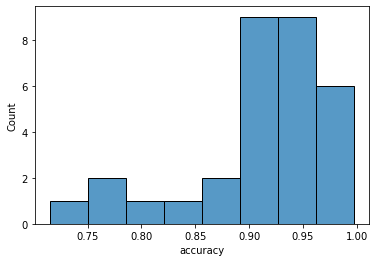

In [22]:
accuracies = df_scores.groupby('sub_num')['accuracy'].mean()
sns.histplot(accuracies)

#### Boxplots of accuracy by target

<AxesSubplot:xlabel='target', ylabel='accuracy'>

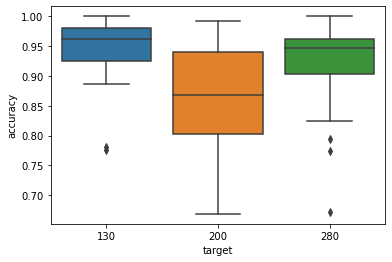

In [30]:
accuracies = df_scores.groupby(['sub_num', 'target'])['accuracy'].mean()
accuracies = pd.DataFrame(accuracies).reset_index()
sns.boxplot(data = accuracies, x = 'target', y = 'accuracy')

#### Boxplots of accuracy by block

<AxesSubplot:xlabel='block_num', ylabel='accuracy'>

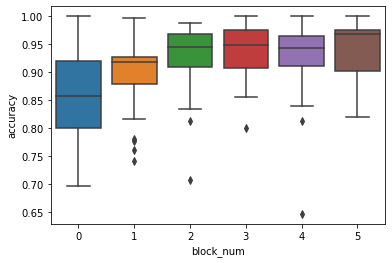

In [73]:
accuracies = df_scores.groupby(['sub_num', 'block_num'])['accuracy'].mean()
accuracies = pd.DataFrame(accuracies).reset_index()
accuracies = accuracies[accuracies.block_num < 6]
sns.boxplot(data = accuracies, x = 'block_num', y = 'accuracy')

## Target plays

In [59]:
# Clean data
df_plays = df[df.tone_num != 1]
df_plays = df_plays[['sub_num', 'block_num', 'target', 'n_target_plays']]
df_plays = df_plays[df_plays.n_target_plays < 50]
df_plays = df_plays[df_plays.block_num != 0]
df_plays = df_plays[df_plays.block_num != 6]
df_plays = df_plays.dropna()

# Calculate means by sub
df_plays = df_plays.groupby(['sub_num', 'target', 'block_num'])['n_target_plays'].mean()
df_plays = pd.DataFrame(df_plays).reset_index()

df_plays

#### Histogram of target plays across subjects

<AxesSubplot:xlabel='n_target_plays', ylabel='Count'>

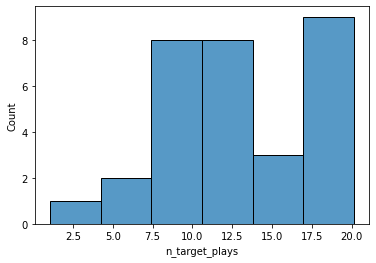

In [62]:
df_plays_hist = df_plays.groupby(['sub_num'])['n_target_plays'].mean()
sns.histplot(df_plays_hist)

#### Boxplots of target plays by target freq and block number

<AxesSubplot:xlabel='target', ylabel='n_target_plays'>

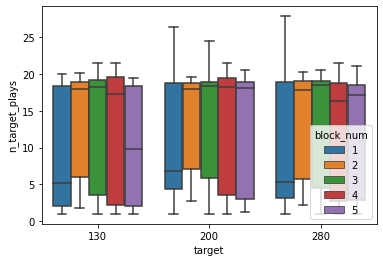

In [61]:
sns.boxplot(data = df_plays, x = 'target', y = 'n_target_plays', hue = 'block_num')